# CASA0007 QM Coursework 3

This version explores the moderator and mediator mechanisms.

In [1]:
# Import library

import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from math import log

## Read and Prepare Variables

### Stressor (S): Green Cover

In [2]:
# Read NDVI
ndvi_cols = ['lb_code', 'lb_name', 'percent_green']
ndvi = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'green_cover_borough_summary_0.05.xlsx'),
                         sheet_name = 'borough_green_cover', usecols = ndvi_cols)

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi.sort_values(by = ['lb_name'], ascending=True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

# Rename column
ndvi.drop('lb_name', axis = 1, inplace = True)
ndvi.rename({'lb_code': 'Area'}, axis = 1, inplace = True)

### Outcome (O): Well-being

In [3]:
# Read well-being
wellbeing = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'personal-well-being-borough.xlsx'),
                         sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
wellbeing_cols = ['Life Satisfaction', 'Worthwhile', 'Happiness']
year = '2011/12'
wellbeing.rename({year: wellbeing_cols[0],
                 year+'.1': wellbeing_cols[1],
                 year+'.2': wellbeing_cols[2],
                 year+'.3': 'Anxiety'},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + wellbeing_cols + ['Anxiety']]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing.drop(wellbeing[wellbeing.Area == "City of London"].index, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)
wellbeing.drop('Code', axis = 1, inplace = True)

# Set data type
wellbeing[wellbeing_cols + ['Anxiety']] = wellbeing[wellbeing_cols + ['Anxiety']].astype('float', copy = False)

### Control

#### Control 1 (C1): Age + Control 2 (C2): Health

In [4]:
# Read self-reported health and age profile
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'msoa-data.csv'),
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health.iloc[i,2] = age_health.iloc[i,2][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+',
           'MSOA Name': 'Area'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Very_good',
               health_cols[1]: 'Good',
               health_cols[2]: 'Fair',
               health_cols[3]: 'Bad',
               health_cols[4]: 'Very_bad',
              'MSOA Name': 'Area'},
              axis = 1, inplace = True)

#### Control 3 (C3): Economic Activity

In [5]:
# Read economic inactivity and rename columns for easy reference
econ_cols = ['Code', 'Area', 'percent; Jan 2011-Dec 2011']
economic = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'economic-inactivity.csv'),
                         usecols = econ_cols, 
                         low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Econ_inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)
economic.drop('Code', axis = 1, inplace = True)

# Change data type
economic.Econ_inactive = economic.Econ_inactive.astype('float', copy = False)

In [6]:
# Read unemployment rate
unemployment_cols = ['Code', 'Area', 'Jan 2011-Dec 2011']
unemployment = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'mb-unemployment-rates.xlsx'), 
                             usecols = unemployment_cols, sheet_name = 'Rates')

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
unemployment.dropna(axis = 0, inplace = True)
unemployment = unemployment[unemployment['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
unemployment.drop(unemployment[unemployment.Area == 'City of London'].index, inplace = True)
unemployment = unemployment.reset_index(drop = True)

# Change data type
unemployment['Jan 2011-Dec 2011'] = unemployment['Jan 2011-Dec 2011'].astype('float', copy = False)

In [7]:
# Compute unemployment rate among economically active
economic['Unemployed'] = ((100 - economic.Econ_inactive)/100) * (unemployment['Jan 2011-Dec 2011']/100) * 100

# Compute employment rate among economically active
economic['Employed'] = 100 - economic.Econ_inactive - economic.Unemployed

### Perceived Control

#### Perceived Control 1 (P1): Physical Exercise

In [8]:
# Read in physical exercise (from 2012)
exercise = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'LSD21-APS-Physical-Activity-Levels.xlsx'),
                         sheet_name = '2012', usecols = ['GSS_Code', 'Region', 'Active'])

# Keep only data on London boroughs (Area Code starts with E09)
exercise = exercise[exercise['GSS_Code'].str.match(r'E09')].sort_values(by = ['GSS_Code'], ascending=True)
exercise = exercise.reset_index(drop = True)
exercise.drop('GSS_Code', axis = 1, inplace = True)

# Convert 'Active' to percentage
exercise.Active = exercise.Active*100

# Rename columns
exercise.rename({'Region': 'Area'}, axis = 1, inplace = True)

#### Perceived Control 2 (P2): Air Quality

In [9]:
# Read in air quality (from 2013)
air_quality = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'NO2_AnnualMean_2013_PopulationData.xlsx'),
                            sheet_name = 'Borough exceeding 40', skiprows = 4, 
                            usecols=['Borough Name', 'PopExc2013 %'])
air_quality['Borough Name'] = air_quality['Borough Name'].str.replace('&', 'and')

# Drop City of London
air_quality.drop(air_quality[air_quality['Borough Name'] == 'City of London'].index, inplace = True)
air_quality = air_quality.reset_index(drop = True)

# Log
air_quality['log_PopExc2013%'] = air_quality['PopExc2013 %'].apply(log)
air_quality.drop('PopExc2013 %', axis = 1, inplace = True)

# Rename columns
air_quality.rename({'Borough Name': 'Area'},
                  axis = 1, inplace = True)

#### Perceived Control 3 (P3): Anxiety

In [10]:
anxiety = wellbeing.drop(wellbeing_cols, axis = 1)
wellbeing.drop('Anxiety', axis = 1, inplace = True)

### Control x Stressor

#### CS1: Greenery x Age

In [11]:
# Merge dataframe
ndvi_age = pd.merge(ndvi, age, on = 'Area')

# Mulitply the columns
for i in age.columns.tolist()[1:]:
    ndvi_age[i] = ndvi_age['percent_green'] * ndvi_age[i]
    ndvi_age.rename({i: ('green_x_'+i)}, axis = 1, inplace = True)

ndvi_age.drop('percent_green', axis = 1, inplace = True)

#### CS2: Greenery x Health

In [12]:
# Merge dataframe
ndvi_health = pd.merge(ndvi, health, on = 'Area')

# Mulitply the columns
for i in health.columns.tolist()[1:]:
    ndvi_health[i] = ndvi_health['percent_green'] * ndvi_health[i]
    ndvi_health.rename({i: ('green_x_'+i)}, axis = 1, inplace = True)

ndvi_health.drop('percent_green', axis = 1, inplace = True)

#### CS3: Greenery x Economic Activity

In [13]:
# Merge dataframe
ndvi_economic = pd.merge(ndvi, economic, left_on = 'Area', right_on = 'Area')

# Mulitply the columns
for i in economic.columns.tolist()[1:]:
    ndvi_economic[i] = ndvi_economic['percent_green'] * ndvi_economic[i]
    ndvi_economic.rename({i: ('green_x_'+i)}, axis = 1, inplace = True)

ndvi_economic.drop('percent_green', axis = 1, inplace = True)

## Step 1: Regression of Outcome Variable

In [14]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [15]:
# Define function to extract outliers based on Tukey fences

def re_outliers(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences

    :param df: the pandas dataframe
    :param col_name: the column being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [area] that have been removed
    '''

    # Initialize
    df_clean = df
    outliers_areas = []
    temp_areas = []

    while True:
    
        # Compute quartiles and IQR
        q1 = df_clean[col_name].quantile(0.25)
        q3 = df_clean[col_name].quantile(0.75)
        iqr = q3 - q1
        # Compute Tukey fences
        lo_tukey = q1 - 1.5*iqr
        hi_tukey = q3 + 1.5*iqr
    
        # Locate the rows and areas that are outside the Tukey fences
        outliers_rows = df_clean.index[(df_clean[col_name] < lo_tukey) | (df_clean[col_name] > hi_tukey)]
        
        if len(outliers_rows) > 0:
            temp_areas = df_clean['Area'][outliers_rows].values.tolist()
            outliers_areas = list(set(outliers_areas + temp_areas))
            df_clean = df_clean.drop(index = outliers_rows)
        else:
            break
    
    # Return both cleaned df and outlier areas
    return df_clean, sorted(outliers_areas)

In [16]:
# Define function to remove outliers in paired samples

def re_outliers_paired(df, col_name):

    '''
    Remove the outliers from dataframe based on Tukey fences in paired fashion for multiple columns

    :param df: the pandas dataframe
    :param col_name: the list of column(s) being checked for outliers
    :return: (1) dataframe with outliers removed, and (2) outliers [local authority area] that have been removed
    '''
    # initialize list to hold outlier areas
    outliers_area = []
    
    # For each column
    for col in col_name:
        # get outliers for the column
        temp_df, temp_outliers = re_outliers(df, col)
        # find all unique areas
        outliers_area = list(set(outliers_area + temp_outliers))
    
    outliers_area = sorted(outliers_area)
    
    # For all outlier areas
    df_clean = df
    for i in outliers_area:
        # Drop from df
        df_clean = df_clean.drop(df.index[df['Area'] == i])
    
    return df_clean, outliers_area

In [17]:
# Define function to perform backwards regression using p-value as selection criterion

def back_regress(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

### Outcome on control

#### Outcome on C1 (Age)

CHECKING FOR COLLINEARITY
Dropping: Age_0-15
Dropping: Age_45-64
Dropping: Age_65+


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     8.649
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00625
Time:                        20:58:17   Log-Likelihood:                 17.592
No. Observations:                  32   AIC:                            -31.18
Df Residuals:                      30   BIC:                            -28.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


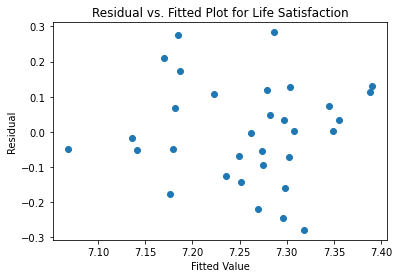



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     29.08
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           7.69e-06
Time:                        20:58:17   Log-Likelihood:                 22.879
No. Observations:                  32   AIC:                            -41.76
Df Residuals:                      30   BIC:                            -38.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

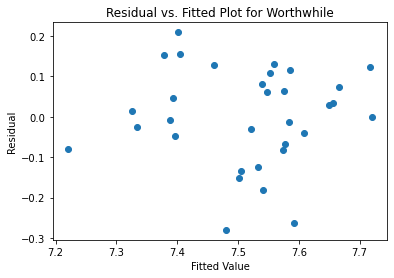



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: Age_30-44
Dropping: Age_15-29
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:17   Log-Likelihood:                 18.567
No. Observations:                  32   AIC:                            -35.13
Df Residuals:                      31   BIC:                            -33.67
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

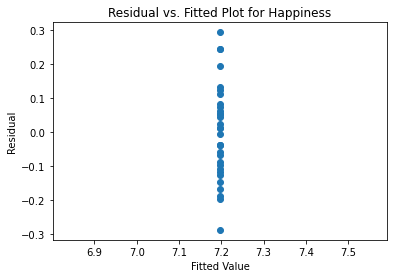

In [18]:
# Merge data
data = pd.merge(wellbeing, age, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

#### Outcome on C2 (Health)

CHECKING FOR COLLINEARITY
Dropping: Very_good
Dropping: Bad


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
Dropping: Fair
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     15.85
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.23e-05
Time:                        20:58:17   Log-Likelihood:                 25.356
No. Observations:                  32   AIC:                            -44.71
Df Residuals:                      29   BIC:                            -40.31
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


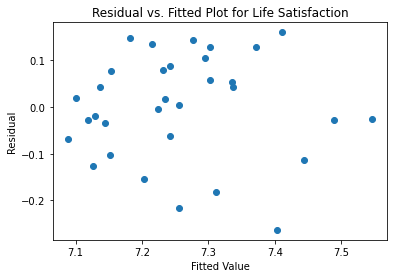



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     16.75
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           1.99e-06
Time:                        20:58:18   Log-Likelihood:                 28.481
No. Observations:                  32   AIC:                            -48.96
Df Residuals:                      28   BIC:                            -43.10
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

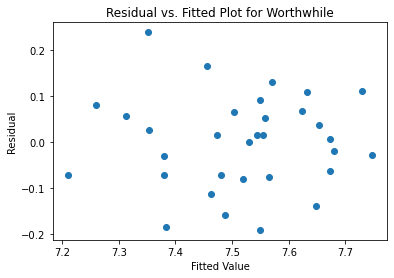



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: Fair
Dropping: Good
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     5.681
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0237
Time:                        20:58:18   Log-Likelihood:                 21.342
No. Observations:                  32   AIC:                            -38.68
Df Residuals:                      30   BIC:                            -35.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

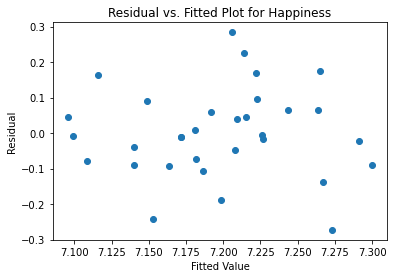

In [19]:
# Merge data
data = pd.merge(wellbeing, health, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

#### Outcome on C3 (Economic Activity)

CHECKING FOR COLLINEARITY
Dropping: Econ_inactive


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
Dropping: Employed
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     43.73
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.55e-07
Time:                        20:58:18   Log-Likelihood:                 27.926
No. Observations:                  32   AIC:                            -51.85
Df Residuals:                      30   BIC:                            -48.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


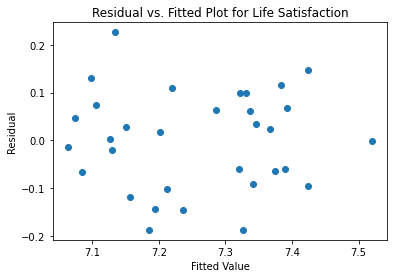



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
Dropping: Employed
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     14.72
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000597
Time:                        20:58:18   Log-Likelihood:                 18.424
No. Observations:                  32   AIC:                            -32.85
Df Residuals:                      30   BIC:                            -29.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

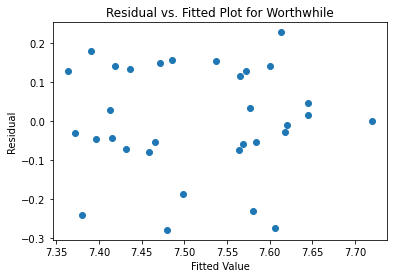



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: Employed
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     16.41
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000332
Time:                        20:58:18   Log-Likelihood:                 25.548
No. Observations:                  32   AIC:                            -47.10
Df Residuals:                      30   BIC:                            -44.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

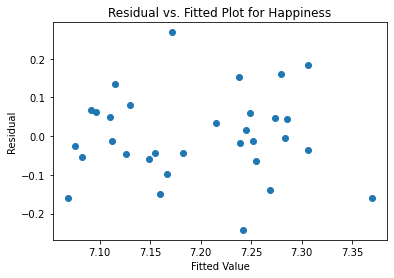

In [20]:
# Merge data
data = pd.merge(wellbeing, economic, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

### Outcome on stressor

CHECKING FOR COLLINEARITY


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.531
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0416
Time:                        20:58:19   Log-Likelihood:                 15.789
No. Observations:                  32   AIC:                            -27.58
Df Residuals:                      30   BIC:                            -24.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

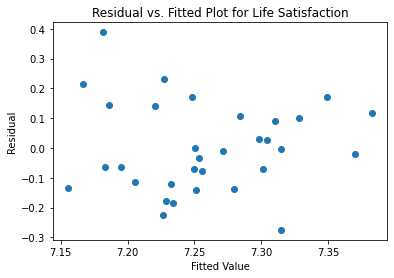



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     13.24
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00102
Time:                        20:58:19   Log-Likelihood:                 17.885
No. Observations:                  32   AIC:                            -31.77
Df Residuals:                      30   BIC:                            -28.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

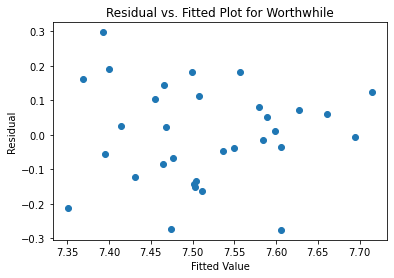



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:19   Log-Likelihood:                 18.567
No. Observations:                  32   AIC:                            -35.13
Df Residuals:                      31   BIC:                            -33.67
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

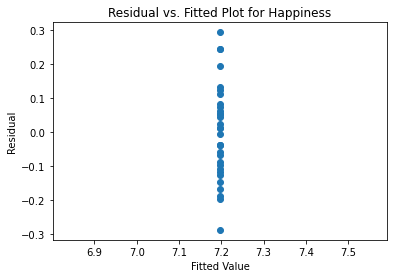

In [21]:
# Merge data
data = pd.merge(wellbeing, ndvi, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

### Outcome on Control x Stressor

#### Outcome on CS1: Greenery x Age

CHECKING FOR COLLINEARITY
Dropping: green_x_Age_45-64


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: ['Richmond upon Thames']
Dropping: green_x_Age_15-29
Dropping: green_x_Age_30-44
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     11.16
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000272
Time:                        20:58:19   Log-Likelihood:                 23.140
No. Observations:                  31   AIC:                            -40.28
Df Residuals:                      28   BIC:                            -35.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    

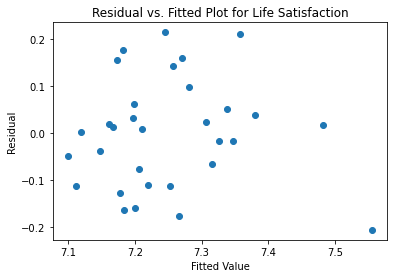



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: ['Richmond upon Thames']
Dropping: green_x_Age_0-15
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     11.21
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           5.88e-05
Time:                        20:58:19   Log-Likelihood:                 24.487
No. Observations:                  31   AIC:                            -40.97
Df Residuals:                      27   BIC:                            -35.24
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------

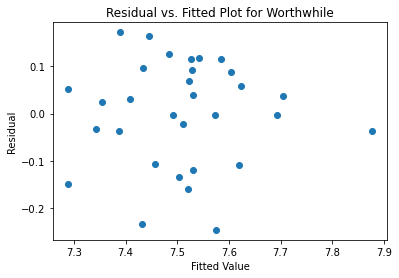



PERFORMING REGRESSION ON:HAPPINESS
Outliers: ['Richmond upon Thames']
Dropping: green_x_Age_15-29
Dropping: green_x_Age_30-44
Dropping: green_x_Age_0-15
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.790
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0227
Time:                        20:58:19   Log-Likelihood:                 20.321
No. Observations:                  31   AIC:                            -36.64
Df Residuals:                      29   BIC:                            -33.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P

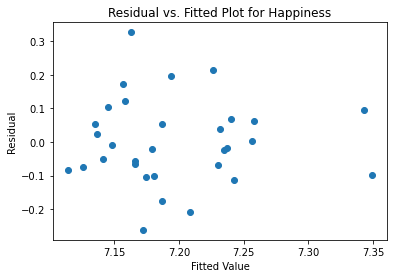

In [22]:
# Merge data
data = pd.merge(wellbeing, ndvi_age, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

#### Outcome on CS2: Greenery x Health 

CHECKING FOR COLLINEARITY
Dropping: green_x_Fair
Dropping: green_x_Bad
Dropping: green_x_Good


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     11.10
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000263
Time:                        20:58:20   Log-Likelihood:                 22.636
No. Observations:                  32   AIC:                            -39.27
Df Residuals:                      29   BIC:                            -34.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>

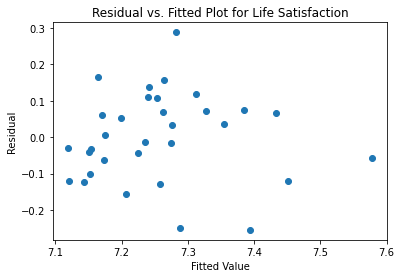



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     13.84
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           6.02e-05
Time:                        20:58:20   Log-Likelihood:                 22.759
No. Observations:                  32   AIC:                            -39.52
Df Residuals:                      29   BIC:                            -35.12
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

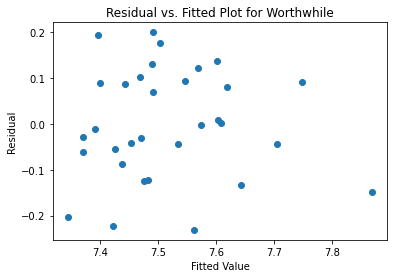



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: green_x_Very_bad
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5.633
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0242
Time:                        20:58:20   Log-Likelihood:                 21.320
No. Observations:                  32   AIC:                            -38.64
Df Residuals:                      30   BIC:                            -35.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

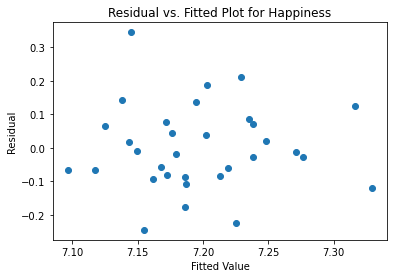

In [23]:
# Merge data
data = pd.merge(wellbeing, ndvi_health, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

#### Outcome on CS3: Greenery x Economic Activity

CHECKING FOR COLLINEARITY


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: []
Dropping: green_x_Econ_inactive
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     15.91
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.17e-05
Time:                        20:58:20   Log-Likelihood:                 25.388
No. Observations:                  32   AIC:                            -44.78
Df Residuals:                      29   BIC:                            -40.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------

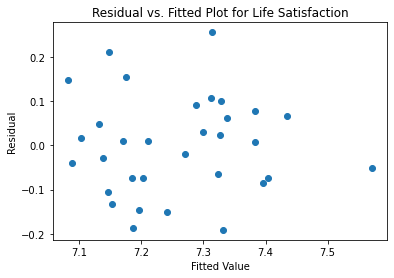



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: []
Dropping: green_x_Econ_inactive
Dropping: green_x_Unemployed
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     15.52
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000451
Time:                        20:58:20   Log-Likelihood:                 18.707
No. Observations:                  32   AIC:                            -33.41
Df Residuals:                      30   BIC:                            -30.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------

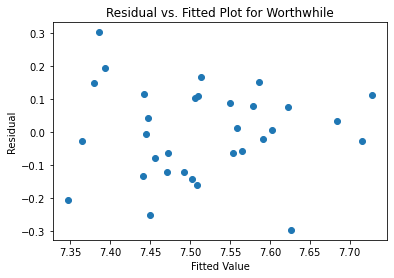



PERFORMING REGRESSION ON:HAPPINESS
Outliers: []
Dropping: green_x_Econ_inactive
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     4.975
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0139
Time:                        20:58:20   Log-Likelihood:                 23.286
No. Observations:                  32   AIC:                            -40.57
Df Residuals:                      29   BIC:                            -36.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

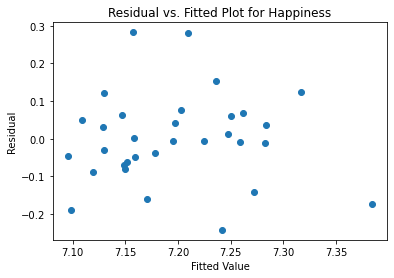

In [24]:
# Merge data
data = pd.merge(wellbeing, ndvi_economic, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

## Step 2: Regression with Perceived Control

### P on C, S and CS

#### P1: Exercise on C1: Age

In [25]:
data_reout.head(3)

,Area,Happiness,green_x_Econ_inactive,green_x_Unemployed,green_x_Employed
0,Barking and Dagenham,6.91,1121.153417,363.865245,2435.098180
1,Barnet,7.26,1432.459189,349.357658,4017.613069
2,Bexley,7.22,995.705344,263.690243,3032.437792


CHECKING FOR COLLINEARITY
Dropping: Age_0-15
Dropping: Age_45-64
Dropping: Age_65+


Outliers: []
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     8.273
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00144
Time:                        20:58:21   Log-Likelihood:                -87.758
No. Observations:                  32   AIC:                             181.5
Df Residuals:                      29   BIC:                             185.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


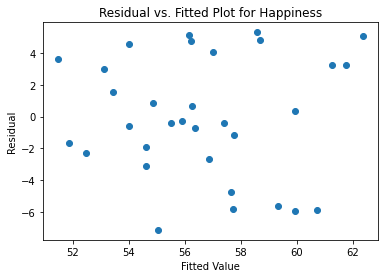

In [26]:
# Merge data
data = pd.merge(exercise, age, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = age.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P1: Exercise on C2: Health

CHECKING FOR COLLINEARITY
Dropping: Very_good
Dropping: Bad


Outliers: []
Dropping: Fair
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     12.62
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000114
Time:                        20:58:21   Log-Likelihood:                -84.963
No. Observations:                  32   AIC:                             175.9
Df Residuals:                      29   BIC:                             180.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


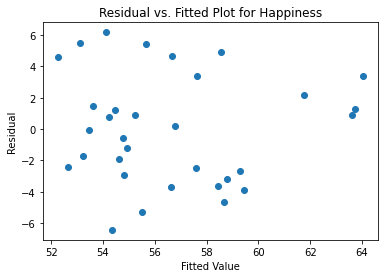

In [27]:
# Merge data
data = pd.merge(exercise, health, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = health.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P1: Exercise on C3: Economic Activity

CHECKING FOR COLLINEARITY


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: Econ_inactive


Outliers: []
Dropping: Employed
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     6.531
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0159
Time:                        20:58:21   Log-Likelihood:                -91.830
No. Observations:                  32   AIC:                             187.7
Df Residuals:                      30   BIC:                             190.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

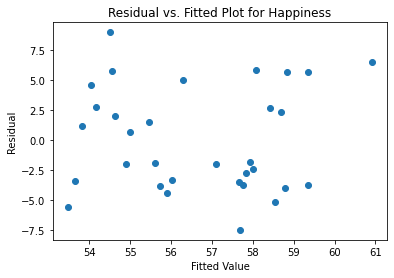

In [28]:
# Merge data
data = pd.merge(exercise, economic, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = economic.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P1: Exercise on S: Green Cover

CHECKING FOR COLLINEARITY


Outliers: []
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:21   Log-Likelihood:                -94.981
No. Observations:                  32   AIC:                             192.0
Df Residuals:                      31   BIC:                             193.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

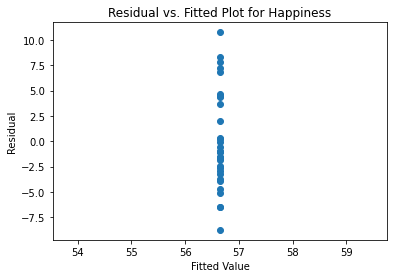

In [29]:
# Merge data
data = pd.merge(exercise, ndvi, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = ndvi.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P1: Exercise on CS1: Greenery x Age

CHECKING FOR COLLINEARITY
Dropping: green_x_Age_45-64


Outliers: ['Richmond upon Thames']
Dropping: green_x_Age_15-29
Dropping: green_x_Age_65+
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     7.654
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00223
Time:                        20:58:21   Log-Likelihood:                -82.889
No. Observations:                  31   AIC:                             171.8
Df Residuals:                      28   BIC:                             176.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|    

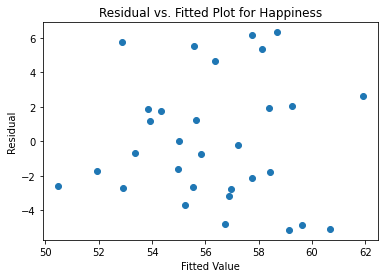

In [30]:
# Merge data
data = pd.merge(exercise, ndvi_age, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = ndvi_age.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P1: Exercise on CS2: Greenery x Health

CHECKING FOR COLLINEARITY
Dropping: green_x_Fair
Dropping: green_x_Bad
Dropping: green_x_Good


Outliers: []
Dropping: green_x_Very_good
Dropping: green_x_Very_bad
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:22   Log-Likelihood:                -94.981
No. Observations:                  32   AIC:                             192.0
Df Residuals:                      31   BIC:                             193.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t   

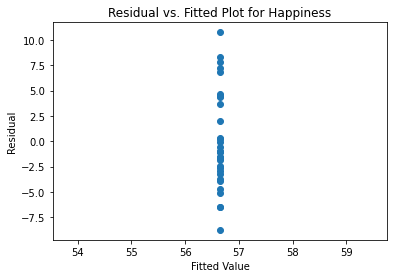

In [31]:
# Merge data
data = pd.merge(exercise, ndvi_health, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = ndvi_health.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P1: Exercise on CS3: Greenery x Economic Activity

CHECKING FOR COLLINEARITY


Outliers: []
Dropping: green_x_Econ_inactive
Dropping: green_x_Employed
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.506
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0421
Time:                        20:58:22   Log-Likelihood:                -92.742
No. Observations:                  32   AIC:                             189.5
Df Residuals:                      30   BIC:                             192.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

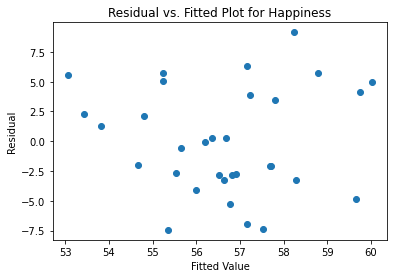

In [32]:
# Merge data
data = pd.merge(exercise, ndvi_economic, on = 'Area')
dep_var = exercise.columns.tolist()[1:]
var = ndvi_economic.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on C1: Age

CHECKING FOR COLLINEARITY
Dropping: Age_0-15
Dropping: Age_45-64
Dropping: Age_65+


Outliers: []
Dropping: Age_15-29
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     36.11
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           1.36e-06
Time:                        20:58:22   Log-Likelihood:                -43.245
No. Observations:                  32   AIC:                             90.49
Df Residuals:                      30   BIC:                             93.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


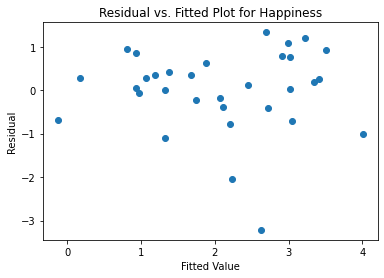

In [33]:
# Merge data
data = pd.merge(air_quality, age, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = age.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on C2: Health

CHECKING FOR COLLINEARITY
Dropping: Very_good
Dropping: Bad




/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Outliers: []
Dropping: Good
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     42.11
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.64e-09
Time:                        20:58:22   Log-Likelihood:                -34.092
No. Observations:                  32   AIC:                             74.18
Df Residuals:                      29   BIC:                             78.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4279   

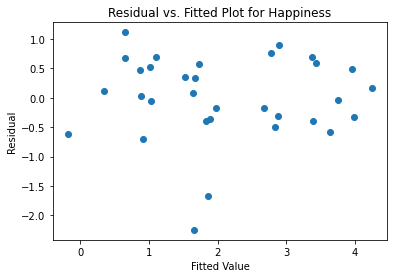

In [34]:
# Merge data
data = pd.merge(air_quality, health, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = health.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on C3: Economic Activity

CHECKING FOR COLLINEARITY
Dropping: Econ_inactive


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)




Outliers: []
Dropping: Unemployed
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.296
Date:                Fri, 07 Jan 2022   Prob (F-statistic):             0.0469
Time:                        20:58:22   Log-Likelihood:                -53.744
No. Observations:                  32   AIC:                             111.5
Df Residuals:                      30   BIC:                             114.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8

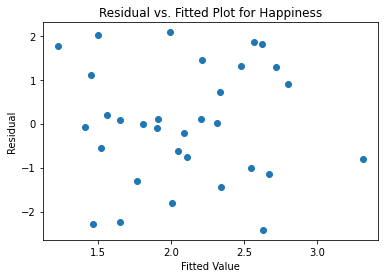

In [35]:
# Merge data
data = pd.merge(air_quality, economic, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = economic.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on S: Green Cover

CHECKING FOR COLLINEARITY


Outliers: []
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     17.60
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000223
Time:                        20:58:23   Log-Likelihood:                -48.499
No. Observations:                  32   AIC:                             101.0
Df Residuals:                      30   BIC:                             103.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const

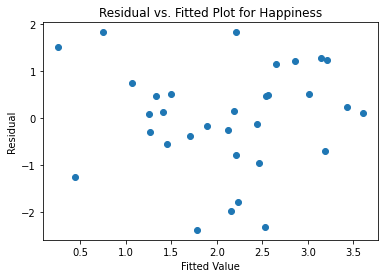

In [36]:
# Merge data
data = pd.merge(air_quality, ndvi, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = ndvi.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on CS1: Greenery x Age

CHECKING FOR COLLINEARITY
Dropping: green_x_Age_45-64


Outliers: ['Richmond upon Thames']
Dropping: green_x_Age_65+
Dropping: green_x_Age_30-44
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     24.34
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           7.51e-07
Time:                        20:58:23   Log-Likelihood:                -38.958
No. Observations:                  31   AIC:                             83.92
Df Residuals:                      28   BIC:                             88.22
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|    

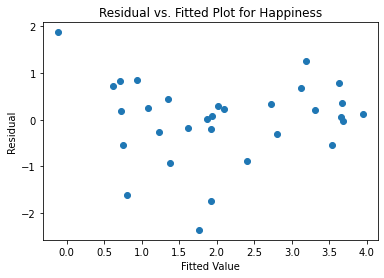

In [37]:
# Merge data
data = pd.merge(air_quality, ndvi_age, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = ndvi_age.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on CS2: Greenery x Health

CHECKING FOR COLLINEARITY
Dropping: green_x_Fair
Dropping: green_x_Bad
Dropping: green_x_Good


Outliers: []
Dropping: green_x_Very_bad
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.940
Date:                Fri, 07 Jan 2022   Prob (F-statistic):            0.00848
Time:                        20:58:23   Log-Likelihood:                -52.129
No. Observations:                  32   AIC:                             108.3
Df Residuals:                      30   BIC:                             111.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025 

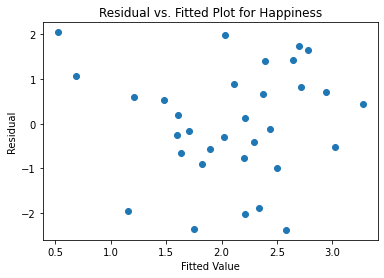

In [38]:
# Merge data
data = pd.merge(air_quality, ndvi_health, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = ndvi_health.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P2: Air Quality on CS3: Greenery x Economic Activity

CHECKING FOR COLLINEARITY


Outliers: []
Dropping: green_x_Econ_inactive
                            OLS Regression Results                            
Dep. Variable:        log_PopExc2013%   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     15.27
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.95e-05
Time:                        20:58:23   Log-Likelihood:                -44.374
No. Observations:                  32   AIC:                             94.75
Df Residuals:                      29   BIC:                             99.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

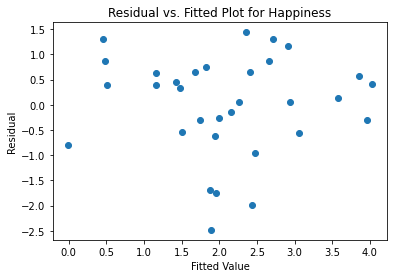

In [39]:
# Merge data
data = pd.merge(air_quality, ndvi_economic, on = 'Area')
dep_var = air_quality.columns.tolist()[1:]
var = ndvi_economic.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on C1: Age

CHECKING FOR COLLINEARITY
Dropping: Age_0-15
Dropping: Age_45-64
Dropping: Age_65+


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow']
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     14.81
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000661
Time:                        20:58:24   Log-Likelihood:                 9.3633
No. Observations:                  29   AIC:                            -14.73
Df Residuals:                      27   BIC:                            -11.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


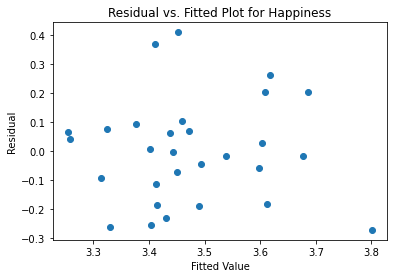

In [40]:
# Merge data
data = pd.merge(anxiety, age, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = age.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on C2: Health

CHECKING FOR COLLINEARITY
Dropping: Very_good


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: Bad


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow']
Dropping: Good
Dropping: Fair
Dropping: Very_bad
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:24   Log-Likelihood:                 3.0240
No. Observations:                  29   AIC:                            -4.048
Df Residuals:                      28   BIC:                            -2.681
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

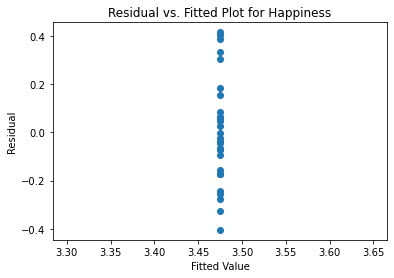

In [41]:
# Merge data
data = pd.merge(anxiety, health, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = health.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on C3: Economic Activity

CHECKING FOR COLLINEARITY
Dropping: Econ_inactive




/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow']
Dropping: Unemployed
Dropping: Employed
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:24   Log-Likelihood:                 3.0240
No. Observations:                  29   AIC:                            -4.048
Df Residuals:                      28   BIC:                            -2.681
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

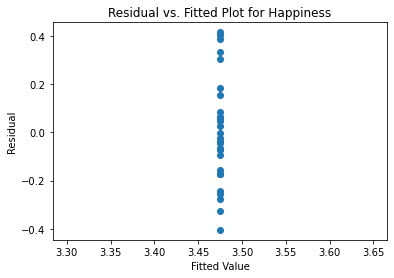

In [42]:
# Merge data
data = pd.merge(anxiety, economic, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = economic.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on S: Green Cover

CHECKING FOR COLLINEARITY


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow']
Dropping: percent_green
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:24   Log-Likelihood:                 3.0240
No. Observations:                  29   AIC:                            -4.048
Df Residuals:                      28   BIC:                            -2.681
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

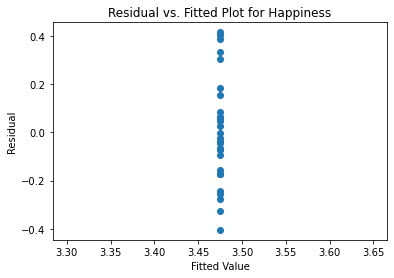

In [43]:
# Merge data
data = pd.merge(anxiety, ndvi, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = ndvi.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on CS1: Greenery x Age

CHECKING FOR COLLINEARITY
Dropping: green_x_Age_45-64


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Richmond upon Thames']
Dropping: green_x_Age_30-44
Dropping: green_x_Age_65+
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     9.880
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000689
Time:                        20:58:24   Log-Likelihood:                 10.837
No. Observations:                  28   AIC:                            -15.67
Df Residuals:                      25   BIC:                            -11.68
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    

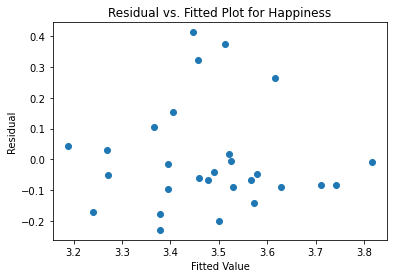

In [44]:
# Merge data
data = pd.merge(anxiety, ndvi_age, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = ndvi_age.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on CS2: Greenery x Health

CHECKING FOR COLLINEARITY
Dropping: green_x_Fair
Dropping: green_x_Bad
Dropping: green_x_Good


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow']
Dropping: green_x_Very_bad
Dropping: green_x_Very_good
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:25   Log-Likelihood:                 3.0240
No. Observations:                  29   AIC:                            -4.048
Df Residuals:                      28   BIC:                            -2.681
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
   

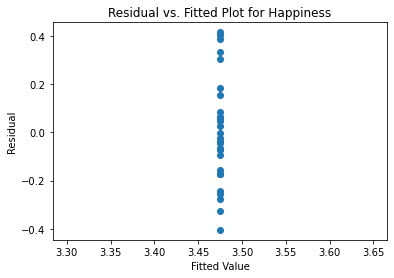

In [45]:
# Merge data
data = pd.merge(anxiety, ndvi_health, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = ndvi_health.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

#### P3: Anxiety on CS3: Greenery x Economic Activity

CHECKING FOR COLLINEARITY


Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow']
Dropping: green_x_Econ_inactive
Dropping: green_x_Unemployed
Dropping: green_x_Employed
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 07 Jan 2022   Prob (F-statistic):                nan
Time:                        20:58:25   Log-Likelihood:                 3.0240
No. Observations:                  29   AIC:                            -4.048
Df Residuals:                      28   BIC:                            -2.681
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err      

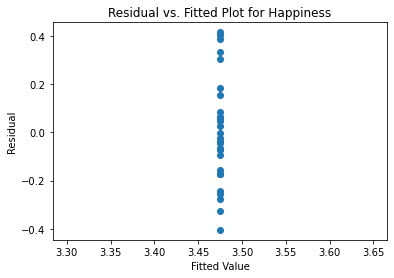

In [46]:
# Merge data
data = pd.merge(anxiety, ndvi_economic, on = 'Area')
dep_var = anxiety.columns.tolist()[1:]
var = ndvi_economic.columns.tolist()[1:]

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data[var])
print('\n')

# Remove outliers first
ind_var = ind_var_data.columns.tolist()
df = data[(['Area']+dep_var+ind_var)]
data_reout, outliers_area = re_outliers_paired(df, (dep_var+ind_var))
print('Outliers:', format(outliers_area))

# Perform regression
#reg_model = sm.OLS(endog=data_reout[dep_var], exog=sm.add_constant(data_reout[ind_var])).fit()
reg_model = back_regress(data_reout[dep_var], data_reout[ind_var])
print(reg_model.summary())

# plot residual vs. fit
plt.scatter(reg_model.fittedvalues, reg_model.resid)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot for ' + cat.title())
plt.show()
print('\n')

### Outcome on C, S, P and CS

CHECKING FOR COLLINEARITY
Dropping: percent_green
Dropping: Age_0-15
Dropping: Very_good
Dropping: Econ_inactive
Dropping: green_x_Age_0-15
Dropping: green_x_Very_good


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: green_x_Fair
Dropping: green_x_Employed
Dropping: green_x_Bad
Dropping: green_x_Age_45-64
Dropping: green_x_Good
Dropping: Very_bad
Dropping: green_x_Age_30-44
Dropping: green_x_Unemployed
Dropping: Age_15-29
Dropping: Age_65+
Dropping: Fair
Dropping: green_x_Very_bad
Dropping: green_x_Age_65+
Dropping: green_x_Econ_inactive
Dropping: Age_30-44


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Tower Hamlets']
Dropping: Age_45-64
Dropping: Active
Dropping: log_PopExc2013%
Dropping: Good
Dropping: green_x_Age_15-29
Dropping: Employed
Dropping: Bad
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     27.63
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           

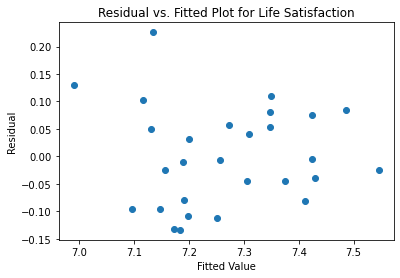



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Tower Hamlets']
Dropping: green_x_Age_15-29
Dropping: Employed
Dropping: log_PopExc2013%
Dropping: Unemployed
Dropping: Anxiety
Dropping: Active
Dropping: Good
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     29.96
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           2.30e-07
Time:                        20:58:26   Log-Likelihood:                 31.625
No. Observations:                  28   AIC:                            -57.25
Df Residuals:                      25   BIC:                            -53.25
Df Model:                           2                                         
Covariance Type:            nonrob

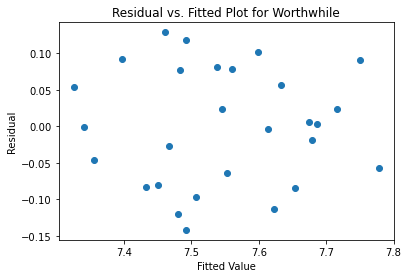



PERFORMING REGRESSION ON:HAPPINESS
Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Tower Hamlets']
Dropping: Employed
Dropping: Good
Dropping: Unemployed
Dropping: Active
Dropping: Anxiety
Dropping: Bad
Dropping: green_x_Age_15-29
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     11.86
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000238
Time:                        20:58:26   Log-Likelihood:                 25.236
No. Observations:                  28   AIC:                            -44.47
Df Residuals:                      25   BIC:                            -40.48
Df Model:                           2                                         
Covariance Type:            nonrobust          

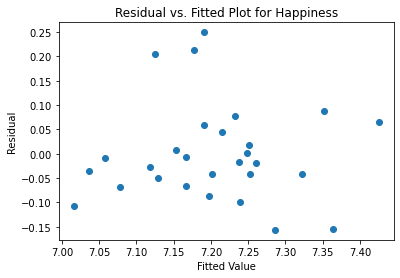

In [47]:
# Merge data
data = pd.merge(wellbeing, ndvi, on = 'Area')
data = data.merge(age, on = 'Area')
data = data.merge(health, on = 'Area')
data = data.merge(economic, on = 'Area')
data = data.merge(exercise, on = 'Area')
data = data.merge(air_quality, on = 'Area')
data = data.merge(anxiety, on = 'Area')
data = data.merge(ndvi_age, on = 'Area')
data = data.merge(ndvi_health, on = 'Area')
data = data.merge(ndvi_economic, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

## Step 3: Regression of Outcome on C, S, P, CS and PS

### Prep PS term

#### PS1: Exercise x Stressor

In [48]:
# Merge dataframe
ndvi_exercise = pd.merge(ndvi, exercise, on = 'Area')

# Mulitply the columns
for i in exercise.columns.tolist()[1:]:
    ndvi_exercise[i] = ndvi_exercise['percent_green'] * ndvi_exercise[i]
    ndvi_exercise.rename({i: ('green_x_'+i)}, axis = 1, inplace = True)

ndvi_exercise.drop('percent_green', axis = 1, inplace = True)

#### PS2: Air Quality x Stressor

In [49]:
# Merge dataframe
ndvi_air_quality = pd.merge(ndvi, air_quality, on = 'Area')

# Mulitply the columns
for i in air_quality.columns.tolist()[1:]:
    ndvi_air_quality[i] = ndvi_air_quality['percent_green'] * ndvi_air_quality[i]
    ndvi_air_quality.rename({i: ('green_x_'+i)}, axis = 1, inplace = True)

ndvi_air_quality.drop('percent_green', axis = 1, inplace = True)

#### PS3: Anxiety x Stressor

In [50]:
# Merge dataframe
ndvi_anxiety = pd.merge(ndvi, anxiety, on = 'Area')

# Mulitply the columns
for i in anxiety.columns.tolist()[1:]:
    ndvi_anxiety[i] = ndvi_anxiety['percent_green'] * ndvi_anxiety[i]
    ndvi_anxiety.rename({i: ('green_x_'+i)}, axis = 1, inplace = True)

ndvi_anxiety.drop('percent_green', axis = 1, inplace = True)

### Regress Outcome on C, S, P, CS and PS

In [51]:
data.columns

Index(['Area', 'Life Satisfaction', 'Worthwhile', 'Happiness', 'percent_green',
       'Age_0-15', 'Age_15-29', 'Age_30-44', 'Age_45-64', 'Age_65+',
       'Very_good', 'Good', 'Fair', 'Bad', 'Very_bad', 'Econ_inactive',
       'Unemployed', 'Employed', 'Active', 'log_PopExc2013%', 'Anxiety',
       'green_x_Age_0-15', 'green_x_Age_15-29', 'green_x_Age_30-44',
       'green_x_Age_45-64', 'green_x_Age_65+', 'green_x_Very_good',
       'green_x_Good', 'green_x_Fair', 'green_x_Bad', 'green_x_Very_bad',
       'green_x_Econ_inactive', 'green_x_Unemployed', 'green_x_Employed'],
      dtype='object')

CHECKING FOR COLLINEARITY
Dropping: percent_green
Dropping: Age_0-15
Dropping: Very_good
Dropping: Econ_inactive
Dropping: green_x_Age_0-15
Dropping: green_x_Very_good
Dropping: green_x_Employed
Dropping: green_x_Fair


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: green_x_Bad
Dropping: green_x_Age_45-64
Dropping: green_x_Good
Dropping: green_x_Active
Dropping: green_x_Anxiety
Dropping: green_x_Age_30-44
Dropping: Very_bad
Dropping: log_PopExc2013%
Dropping: green_x_Unemployed
Dropping: green_x_Econ_inactive
Dropping: Age_65+
Dropping: Fair
Dropping: green_x_Very_bad
Dropping: green_x_Age_65+
Dropping: Age_45-64
Dropping: Good


PERFORMING REGRESSION ON:LIFE SATISFACTION
Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Havering', 'Merton']
Dropping: Age_30-44
Dropping: Active
Dropping: green_x_Age_15-29
Dropping: green_x_log_PopExc2013%
Dropping: Age_15-29
Dropping: Employed
Dropping: Bad
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     30.62
Date:                Fri, 07 J

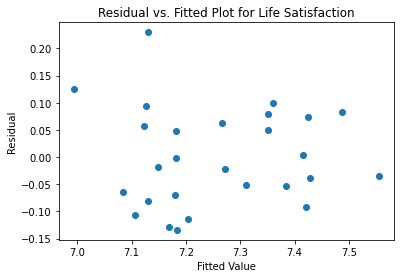



PERFORMING REGRESSION ON:WORTHWHILE
Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Havering', 'Merton']
Dropping: Anxiety
Dropping: green_x_Age_15-29
Dropping: Age_30-44
Dropping: Active
Dropping: Employed
Dropping: green_x_log_PopExc2013%
Dropping: Bad
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     36.53
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           5.22e-08
Time:                        20:58:27   Log-Likelihood:                 29.580
No. Observations:                  27   AIC:                            -53.16
Df Residuals:                      24   BIC:                            -49.27
Df Model:                           2                                         
Covariance Type:       

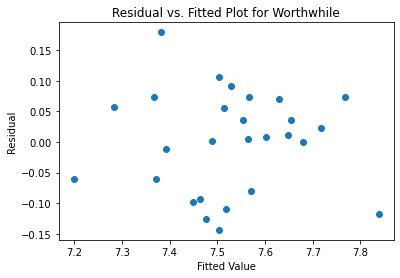



PERFORMING REGRESSION ON:HAPPINESS
Outliers: ['Brent', 'Hammersmith and Fulham', 'Harrow', 'Havering', 'Merton']
Dropping: Age_30-44
Dropping: Active
Dropping: Age_15-29
Dropping: Bad
Dropping: Employed
Dropping: green_x_Age_15-29
Dropping: Anxiety
Dropping: green_x_log_PopExc2013%
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     17.84
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           0.000279
Time:                        20:58:27   Log-Likelihood:                 22.455
No. Observations:                  27   AIC:                            -40.91
Df Residuals:                      25   BIC:                            -38.32
Df Model:                           1                                         
Cova

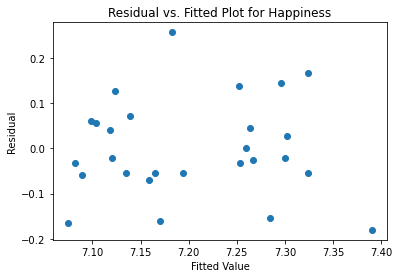

In [52]:
# Merge data
data = data.merge(ndvi_exercise, on = 'Area')
data = data.merge(ndvi_air_quality, on = 'Area')
data = data.merge(ndvi_anxiety, on = 'Area')

# Drop collinear independent variables
print(f'CHECKING FOR COLLINEARITY')
ind_var_data = drop_column_using_vif_(data.drop(['Area'] + wellbeing_cols, axis=1))
ind_var = ind_var_data.columns.tolist()
print('\n')

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Remove outliers first
    df = data[['Area', cat]+ ind_var]
    data_reout, outliers_area = re_outliers_paired(df, ([cat]+ ind_var))
    print('Outliers:', format(outliers_area))

    # Perform regression
    #reg_model = sm.OLS(endog=data_reout[cat], exog=sm.add_constant(data_reout[ind_var])).fit()
    reg_model = back_regress(data_reout[cat], data_reout[ind_var])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')